In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

device = torch.device('cuda:0')

In [2]:
class PUBG_imglike_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        def transfrom2imglike(input):
            output = np.zeros((3,32,32))
            temp = np.array(input)
            for x in range(23):
                for y in range(23):
                    if(x == y):
                        output[0][x][y] = temp[x]
                        output[1][x][y] = temp[x]
                        output[2][x][y] = temp[x]
            return output
        # get one line in csv
        player_id = self.frame.iloc [idx, 0]
        player_stats = self.frame.iloc [idx, [x for x in range(3, 27) if x != 15]].values.astype(np.int_)
        player_stats = torch.tensor(transfrom2imglike(player_stats))
        win_place_perc = torch.tensor(self.frame.iloc [idx, 28])
        if self.transform:
            player_stats = self.transform(player_stats)
        sample = {
            "player_id": player_id, 
            "player_stats": player_stats,
            "win_place_perc": win_place_perc
        }
        return sample
    
def get_dataset(csv_file, train_dataset_size_ratio, batch_size):
    dataset = PUBG_imglike_dataset(csv_file)
    #  `torch.utils.data.random_split` meets server problem and lead to CRASH
    # see also:
    # - a denied fix PR for this problem: https://github.com/pytorch/pytorch/pull/9237 
    #train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor((1-train_dataset_size_ratio) * dataset_size))
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    print("load dataset: train dataset: {}, test dataset: {}.".format(len(train_loader)*batch_size, len(test_loader)*batch_size))
    return (train_loader, test_loader)

# load dataset
csv_file = 'train_small.csv'
train_dataset_size_ratio = 0.9
batch_size = 128
train_loader, test_loader = get_dataset(csv_file, train_dataset_size_ratio, batch_size)

load dataset: train dataset: 1152, test dataset: 128.


In [3]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

In [4]:
def train(model, train_loader, loss_func, optimizer, device):
    total_loss = 0
    # train the model using minibatch
    for i, data in enumerate(train_loader):
        stats, prec = data['player_stats'], data['win_place_perc']
        stats, prec = stats.to(torch.float32).to(device), prec.to(device)

        # forward
        outputs = model(stats)
        loss = loss_func(outputs, prec)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        #if (i + 1) % 10 == 0:
        #    print ("Step [{}/{}] Train Loss: {:.4f}".format(i+1, len(train_loader), loss.item()))
    #print ("Train Loss: {:.4f}".format(loss.item()))
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):

    model.eval()
    with torch.no_grad():
        loss = 0
        total = 0
        
        for i, data in enumerate(val_loader):
            stats, prec = data['player_stats'], data['win_place_perc']
            stats, prec = stats.to(torch.float32).to(device), prec.to(device)

            outputs = model(stats)

            
            loss += (torch.abs(torch.t(outputs) - prec)).sum()
            total += prec.size(0)

            
        accuracy = loss / total
        #print('Test Loss: {:.4f}'.format(accuracy))
        return accuracy
    
def fit(model, num_epochs, optimizer, device):
    loss_func = nn.MSELoss()
    model.to(device)
    if device == torch.device('cuda'):
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    loss_func.to(device)
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        

        # train step
        loss = train(model, train_loader, loss_func, optimizer, device)
        losses.append(loss)
        
        # evaluate step
        accuracy = evaluate(model, test_loader, device)
        accs.append(accuracy)
        
        # print loss
        if (epoch+1) % 10 == 0:
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("Train Loss: {:.4f}".format(loss))
            print('Test Loss: {:.4f}'.format(accuracy))

    show_curve(losses, "train loss")
    show_curve(accs, "test loss")

In [5]:
from torch import nn
import math

class VGG(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg)
        # linear layer
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        """
        cfg: a list define layers this layer contains
            'M': MaxPool, number: Conv2d(out_channels=number) -> BN -> ReLU
        """
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [6]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
vggnet11 = VGG(cfg['VGG11'], 1)
print(vggnet11)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

In [7]:
# training setting
# hyper parameters
num_epochs = 100
lr = 0.01
image_size = 32

# Device configuration, cpu, cuda:0/1/2/3 available
device = torch.device('cuda:0')

optimizer = torch.optim.Adam(vggnet11.parameters(), lr=lr)

Epoch 10/100
Train Loss: 0.0971
Test Loss: 0.2787
Epoch 20/100
Train Loss: 0.0966
Test Loss: 0.2788
Epoch 30/100
Train Loss: 0.0913
Test Loss: 0.2793
Epoch 40/100
Train Loss: 0.0952
Test Loss: 0.2786
Epoch 50/100
Train Loss: 0.0876
Test Loss: 0.2788
Epoch 60/100
Train Loss: 0.0914
Test Loss: 0.2787
Epoch 70/100
Train Loss: 0.0941
Test Loss: 0.2789
Epoch 80/100
Train Loss: 0.0922
Test Loss: 0.2786
Epoch 90/100
Train Loss: 0.0943
Test Loss: 0.2785
Epoch 100/100
Train Loss: 0.0923
Test Loss: 0.2792


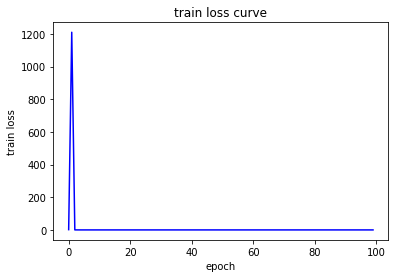

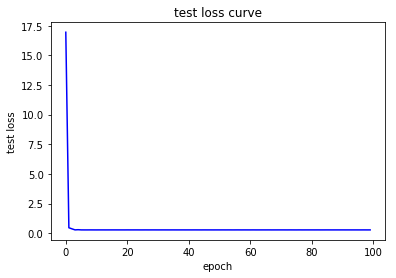

In [8]:
fit(vggnet11, num_epochs, optimizer, device)